In [1]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XY as std

In [2]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [3]:
NUM_SHOTS = 256
SEED = 2022

In [4]:
# setup the datagen model
max_fogi_error_rate = 0.01
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [5]:
prior_covar = max_fogi_error_rate**2*np.eye(target_model.num_params)
uniform_prior_model = target_model.copy()
uniform_prior_model.from_vector(np.random.uniform(0, 1, target_model.num_params))

In [6]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.009748927582832523
mean square error:  0.00041734140099992126


In [7]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [8]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  56 circuits ---
Iterative GST Total Time: 3.4s
--- Iterative GST: [##################################################] 100.0%  96 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  177 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  304 circuits ---
Iterative GST Total Time: 1.1s


In [9]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

germ_length_ranges = {
    0: [0, 56], 
    1: [56, 96], 
    2: [96, 177], 
    3: [177, 304]
}

In [10]:
# run a Kalman filter in the usual way
usual_post_model, usual_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:15<00:00, 19.47it/s]


In [11]:
usual_parameter_history = saved_data[0]
usual_covar_history = saved_data[1]

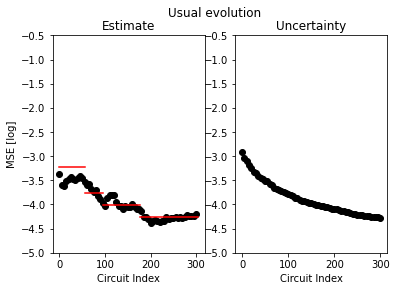

In [12]:
%matplotlib inline
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Usual evolution', usual_parameter_history, mdl_datagen.to_vector(), usual_covar_history, yrange, mle_estimates, germ_length_ranges, plt_spacing)

In [66]:
class PoissonKalmanFilter():
    def __init__(self, model, P0):
        self.model = model.copy()
        self.num_params = len(model.to_vector())
        self.P = P0
        
        self.param_hist = [model.to_vector()]
        self.covar_hist = [self.P]
        
    def update(self, circ, count_vec, Q=None):
        prior_covar = self.P
        x_prior = self.model.to_vector()
        hilbert_dims = 2**(circ.width)
        
        jacob = matrix_from_jacob(self.model.sim.dprobs(circ), 2**circ.width)
        
        P = prior_covar 
        if Q is not None:
            P += Q
        
        p_pred = vector_from_outcomes(self.model.probabilities(circ), hilbert_dims)
        N_counts = sum(count_vec)
        c_pred = N_counts*p_pred
        
        obs_covar = np.diag(c_pred+np.ones(len(c_pred)))
        obs_mat = N_counts*jacob
        
        Kgain = P@obs_mat.T@np.linalg.inv(obs_mat@P@obs_mat.T + obs_covar)
        
        x_post = x_prior + Kgain@(count_vec - c_pred)
        
        covar_proj = np.eye(P.shape[0]) - Kgain@obs_mat
        post_covar = covar_proj@P@covar_proj.T + Kgain@obs_covar@Kgain.T
        
        self.param_hist.append(x_post)
        self.covar_hist.append(post_covar)
        
        self.model.from_vector(x_post)
        self.P = post_covar
        
    def observe_model(self, mdl_in, circ_list, counts):
        for circ in tqdm(circ_list):
            obs_pvec = vector_from_outcomes(mdl_in.probabilities(circ), 2**circ.width)
            obs_cvec = np.random.multinomial(counts, obs_pvec)
            self.update(circ, obs_cvec)

In [67]:
def pfilter_dataset(prior_model, prior_covar, dataset, circ_list):
    pkf = PoissonKalmanFilter(prior_model.copy(), prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        pkf.update(circ, cvec)
    return pkf

In [68]:
# run Poission filter in the usual way
pkf_post = pfilter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:16<00:00, 18.85it/s]


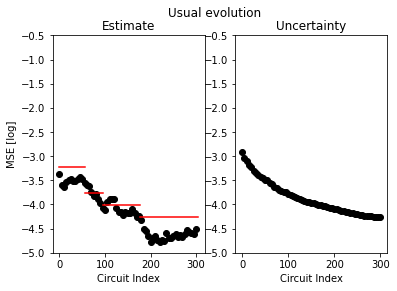

In [69]:
%matplotlib inline
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Usual evolution', pkf_post.param_hist, mdl_datagen.to_vector(), pkf_post.covar_hist, yrange, mle_estimates, germ_length_ranges, plt_spacing)

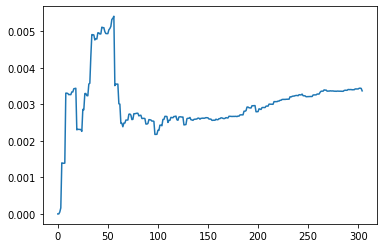

In [70]:
plt.plot([np.linalg.norm(usual_parameter_history[i] - pkf_post.param_hist[i]) for i in range(len(pkf_post.param_hist))]) 

In [71]:
pkf = PoissonKalmanFilter(mle_estimates[0], prior_covar)

In [72]:
pkf.observe_model(mdl_datagen, edesign.circuit_lists[-1], 100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:17<00:00, 17.49it/s]


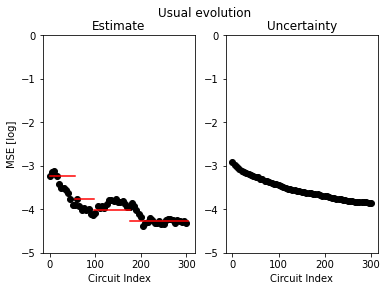

In [73]:
make_error_plot('Usual evolution', pkf.param_hist, mdl_datagen.to_vector(), pkf.covar_hist, [-5, 0], mle_estimates, germ_length_ranges, plt_spacing)